In [1]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behavi

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/unlocking-language-understanding-with-the-multin")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/unlocking-language-understanding-with-the-multin


In [3]:
import torch
from torch.utils.data import DataLoader

# DistilBERT 모델용 tokenizer 로드 (pretrained)
# 이 tokenizer는 문장을 토큰화해서 모델이 이해할 수 있는 input_ids로 변환해줌
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://hu

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [4]:
import random
import pandas as pd


def load_data(path, nrows=None):
  df = pd.read_csv(path, nrows=nrows, keep_default_na=False)
  data = []
  for _, row in df.iterrows():
    if len(row['premise']) * len(row['hypothesis']) != 0:
      data.append({'premise': row['premise'], 'hypothesis': row['hypothesis'], 'label': row['label']})

  return data

# 경로 : load_data(path + '/불러올파일명.csv', nrows=1000)
train_data = load_data(path+'/train.csv', nrows=1000)
test_data = load_data(path+'/validation_matched.csv', nrows=1000)

In [5]:
train_data[0], test_data[0]

({'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.',
  'hypothesis': 'Product and geography are what make cream skimming work. ',
  'label': 1},
 {'premise': 'The new rights are nice enough',
  'hypothesis': 'Everyone really likes the newest benefits ',
  'label': 1})

In [6]:
def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['premise'] + row['hypothesis'])

  texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    train_data, batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_data, batch_size=64, shuffle=False, collate_fn=collate_fn
)

In [7]:
from torch import nn


class TextClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
    #입력차원수 : 768(DistillBERT의 hidden size)
    #출력차원수 : 3(MNLI-3way classification:Entailment(함의)/Cpmtradoctopm(모순)/Neutral(중립))
    self.classifier = nn.Linear(768, 3)

  def forward(self, x):
    x = self.encoder(x)['last_hidden_state']
    x = self.classifier(x[:, 0])

    return x


model = TextClassifier()

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [8]:
for param in model.encoder.parameters():
  param.requires_grad = False

In [9]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

def accuracy(model, dataloader):
    cnt = 0      # 전체 샘플 수
    acc = 0      # 정답 개수 누적

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)  # 로짓(logit) 출력
        preds = torch.argmax(preds, dim=-1)

        cnt += labels.shape[0]  # 총 샘플 수 누적
        acc += (labels == preds).sum().item()  # 예측이 맞은 수 누적

    return acc / cnt  # 정확도 반환

#학습 과정 시각화 함수
def plot_acc(train_acc, test_acc):
  x = np.arange(len(train_acc))

  plt.plot(x, train_acc, label='train') #학습 데이터 정확도 그래프
  plt.plot(x, test_acc, label='test') #테스트 데이터 정확도 그래프
  plt.legend()
  plt.show()

def plot_loss(losses):
    plt.plot(np.arange(len(losses)), losses, label='train_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Time')
    plt.legend()
    plt.show()

[Epoch 01/50] Loss: 16.0919 | Train Acc: 0.4980 | Test Acc: 0.3830
[Epoch 02/50] Loss: 15.9491 | Train Acc: 0.4980 | Test Acc: 0.3830
[Epoch 03/50] Loss: 15.9896 | Train Acc: 0.5270 | Test Acc: 0.3910
[Epoch 04/50] Loss: 15.9861 | Train Acc: 0.5440 | Test Acc: 0.4040
[Epoch 05/50] Loss: 15.9323 | Train Acc: 0.5250 | Test Acc: 0.3820
[Epoch 06/50] Loss: 15.9859 | Train Acc: 0.5010 | Test Acc: 0.4000
[Epoch 07/50] Loss: 15.8743 | Train Acc: 0.5220 | Test Acc: 0.4030
[Epoch 08/50] Loss: 16.0115 | Train Acc: 0.4880 | Test Acc: 0.3860
[Epoch 09/50] Loss: 15.7736 | Train Acc: 0.4810 | Test Acc: 0.3810
[Epoch 10/50] Loss: 15.9399 | Train Acc: 0.5210 | Test Acc: 0.3920
[Epoch 11/50] Loss: 15.8299 | Train Acc: 0.5410 | Test Acc: 0.4030
[Epoch 12/50] Loss: 15.7852 | Train Acc: 0.5190 | Test Acc: 0.3890
[Epoch 13/50] Loss: 15.6474 | Train Acc: 0.5490 | Test Acc: 0.3930
[Epoch 14/50] Loss: 15.8641 | Train Acc: 0.5570 | Test Acc: 0.4070
[Epoch 15/50] Loss: 15.7148 | Train Acc: 0.5200 | Test Acc: 0.

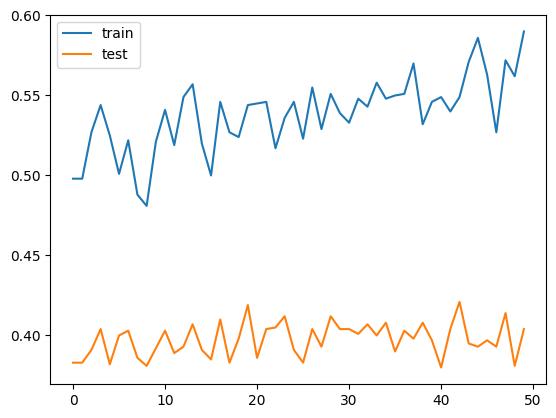

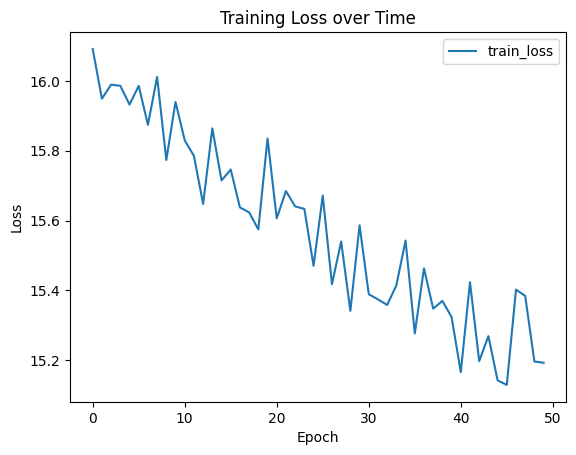

In [12]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt


lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)

train_acc= []
test_acc = []
train_losses = []

n_epochs = 50

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda').long()

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  train_acc.append(accuracy(model, train_loader))
  test_acc.append(accuracy(model, test_loader))
  print(f"[Epoch {epoch+1:02d}/{n_epochs}] Loss: {total_loss:.4f} | Train Acc: {train_acc[-1]:.4f} | Test Acc: {test_acc[-1]:.4f}")

  train_losses.append(total_loss)

plot_acc(train_acc, test_acc) #학습 결과 시각화
plot_loss(train_losses) #손실값 시각화

In [13]:
# 평가 시 gradient 계산 비활성화
with torch.no_grad():
    model.eval()  # 평가 모드로 전환 (계산 비활성화)
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)

    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

=========> Train acc: 0.598 | Test acc: 0.410
